In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phishing-site-urls/phishing_site_urls.csv
/kaggle/input/masks/user.png
/kaggle/input/masks/upvote.png
/kaggle/input/masks/star.png
/kaggle/input/masks/comment.png
/kaggle/input/masks/loc.png
/kaggle/input/masks/masks-wordclouds/user.png
/kaggle/input/masks/masks-wordclouds/upvote.png
/kaggle/input/masks/masks-wordclouds/star.png
/kaggle/input/masks/masks-wordclouds/comment.png
/kaggle/input/masks/masks-wordclouds/loc.png


In [2]:
!pip install selenium

     |████████████████████████████████| 7.2 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 400 kB 52.6 MB/s eta 0:00:01
     |████████████████████████████████| 124 kB 44.7 MB/s eta 0:00:01
     |████████████████████████████████| 159 kB 47.6 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 989 kB/s  eta 0:00:01
     |████████████████████████████████| 58 kB 3.7 MB/s  eta 0:00:01
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 2.0.7 which is incompatible.
ERROR: osmnx 0.15.1 has requirement geopandas>=0.7, but you'll have geopandas 0.6.3 which is incompatible.
ERROR: kubernetes 10.1.0 has requirement pyyaml~=3.12, but you'll have pyyaml 5.3.1 which is incompatible.
ERROR: kaggle 1.5.6 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 2.0.7 which is incompatible.
ERROR: jupyterlab-git 0.10.0 has requirement nbdime<2.0.0,>=1.1.0, but you'll have nbdime 2.0.0 which is incompatible.
ERROR: hype

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import plotly.express as px
import time

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from bs4 import BeautifulSoup 
from selenium import webdriver
import networkx as nx

import pickle

import warnings
warnings.filterwarnings('ignore')

In [4]:
phish_data = pd.read_csv('/kaggle/input/phishing-site-urls/phishing_site_urls.csv')

In [5]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [6]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [7]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [8]:
phish_data.isnull().sum()

URL      0
Label    0
dtype: int64

* **Since it is classification problems so let's see the classes are balanced or imbalances**

In [9]:
label_counts = pd.DataFrame(phish_data.Label.value_counts())

In [10]:
fig = px.bar(label_counts, x=label_counts.index, y=label_counts.Label)
fig.show()

In [11]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [12]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [13]:
tokenizer.tokenize(phish_data.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [14]:
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t))
t1 = time.perf_counter() - t0
print('Time taken ',t1 ,' sec')

Time taken  2.981490573999963  sec


In [15]:
phish_data.sample(5)

,URL,Label,text_tokenized
6372,www.jhjfkj.cn/images/?app=com-d3&amp;us.battle...,bad,"[www, jhjfkj, cn, images, app, com, d, amp, us..."
37890,paypal-activation.com/UeOUU/ONlKU/ULRVX/XRmfN/...,bad,"[paypal, activation, com, UeOUU, ONlKU, ULRVX,..."
212355,medlibrary.org/medwiki/Iowa_Hawkeyes_football,good,"[medlibrary, org, medwiki, Iowa, Hawkeyes, foo..."
435631,spoke.com/info/p3NrLhW/ConnieMojallal,good,"[spoke, com, info, p, NrLhW, ConnieMojallal]"
403044,netflix.com/Movie/Broken-Flowers/70033389,good,"[netflix, com, Movie, Broken, Flowers]"


In [16]:
stemmer = SnowballStemmer("english")

In [17]:
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken ',t1 ,'sec')

Time taken  53.55434663899996 sec


In [18]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
439741,streamaudio.com/listen?station=KMXV_FM,good,"[streamaudio, com, listen, station, KMXV, FM]","[streamaudio, com, listen, station, kmxv, fm]"
187271,ferdielicious.com/2009/07/22/erin-andrews-peep...,good,"[ferdielicious, com, erin, andrews, peephole, ...","[ferdielici, com, erin, andrew, peephol, pictu..."
528835,klasmodel.com/HxZ5Ay,bad,"[klasmodel, com, HxZ, Ay]","[klasmodel, com, hxz, ay]"
85131,sourceforge.net/projects/alde/,good,"[sourceforge, net, projects, alde]","[sourceforg, net, project, ald]"
428800,scu.edu/ethnicstudies/aboutus/faculty.cfm,good,"[scu, edu, ethnicstudies, aboutus, faculty, cfm]","[scu, edu, ethnicstudi, aboutus, faculti, cfm]"


In [19]:
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Time taken 0.27903132799997366 sec


In [20]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
541697,tobeacea.com/rss/feed/stream,bad,"[tobeacea, com, rss, feed, stream]","[tobeacea, com, rss, feed, stream]",tobeacea com rss feed stream
503711,far-infraredsaunas.com/jhg45s,bad,"[far, infraredsaunas, com, jhg, s]","[far, infraredsauna, com, jhg, s]",far infraredsauna com jhg s
208038,lisa.revues.org/1691,good,"[lisa, revues, org]","[lisa, revu, org]",lisa revu org
513197,64.182.19.61/includes/lib/module/,bad,"[includes, lib, module]","[includ, lib, modul]",includ lib modul
44124,paypal.com.com.cgi.bin.webscr.cmd.login.submit...,bad,"[paypal, com, com, cgi, bin, webscr, cmd, logi...","[paypal, com, com, cgi, bin, webscr, cmd, logi...",paypal com com cgi bin webscr cmd login submit...


In [21]:
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [22]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [23]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [24]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '../input/masks/masks-wordclouds/'

In [25]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

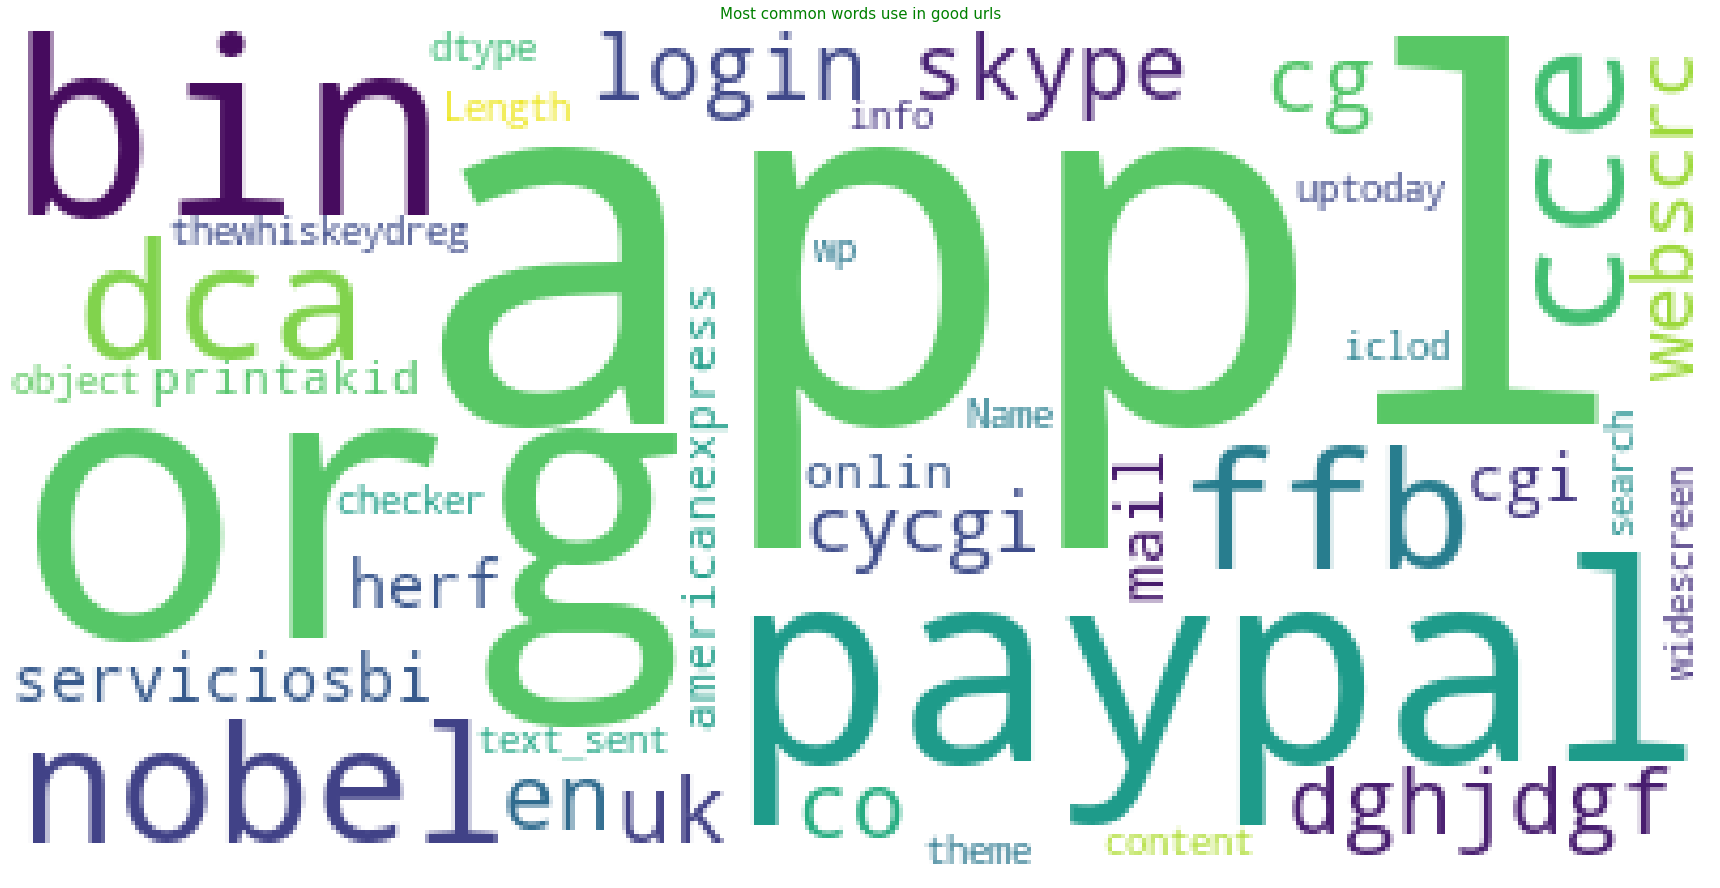

In [66]:
common_text = str(data)
common_mask = np.array(Image.open(d+'star.png'))
plot_wordcloud(common_text, max_words=400, max_font_size=120, title = 'Most common words use in good urls', title_size=15)

In [27]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

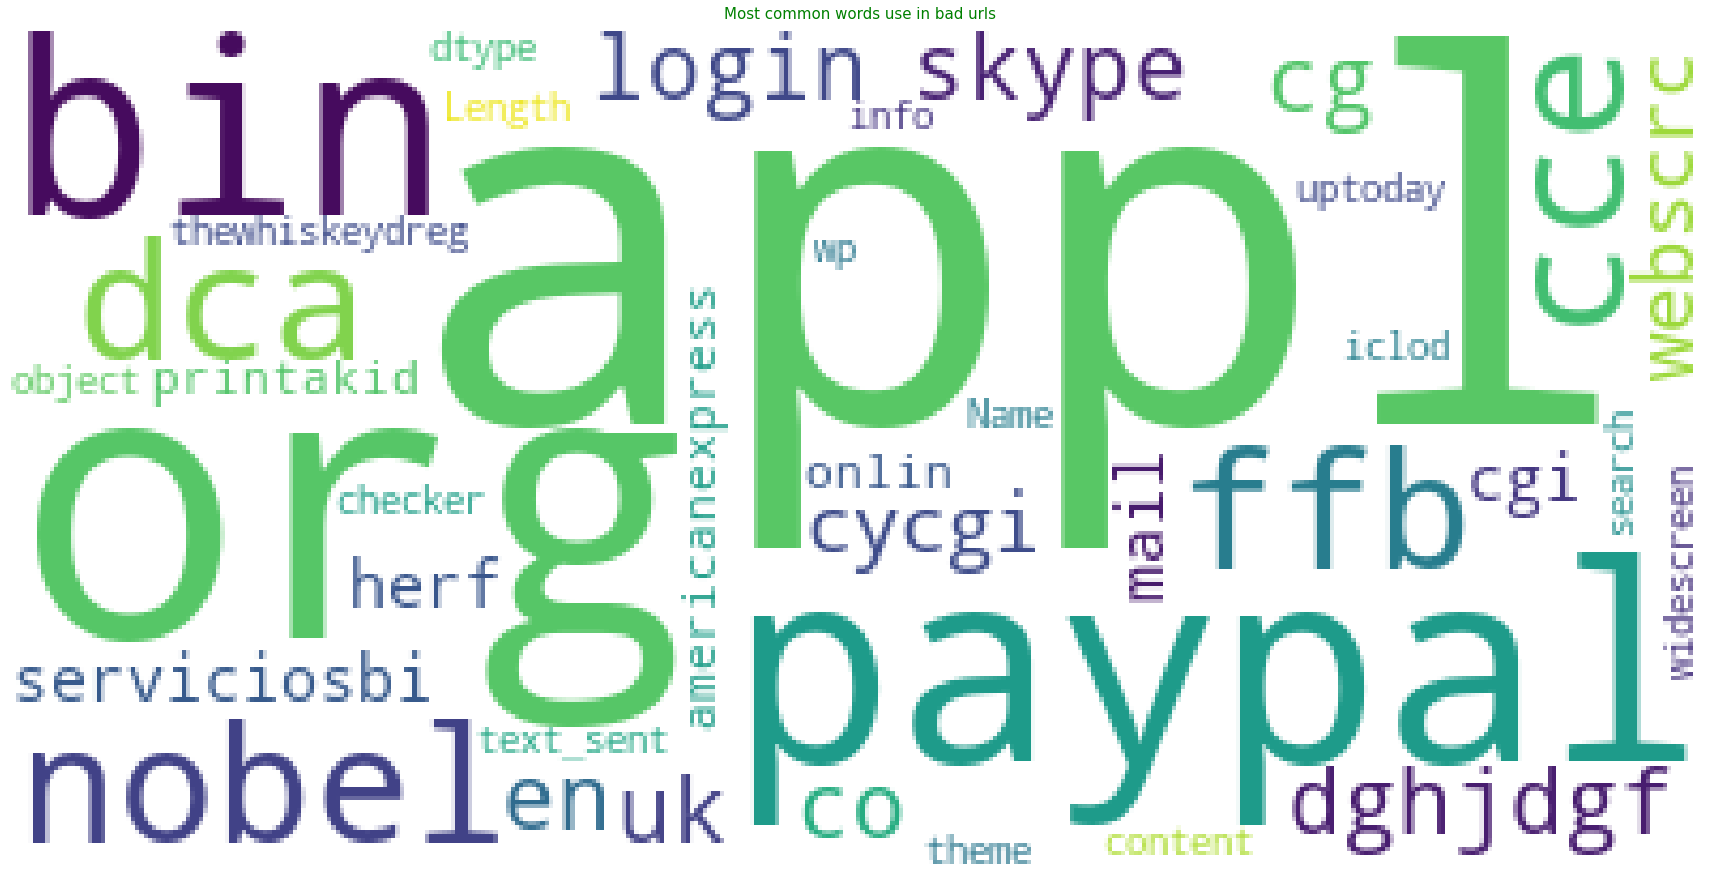

In [67]:
common_text = str(data)
common_mask = np.array(Image.open(d+'comment.png'))
plot_wordcloud(common_text, max_words=400, max_font_size=120, title = 'Most common words use in bad urls', title_size=15)

In [29]:
cv = CountVectorizer()

In [30]:
help(CountVectorizer())

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  -----

In [31]:
feature = cv.fit_transform(phish_data.text_sent)

In [32]:
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

In [34]:
lr = LogisticRegression()

In [35]:
lr.fit(trainX,trainY)

LogisticRegression()

In [36]:
lr.score(testX,testY)

0.9639354289084515

In [37]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9785247409643965
Testing Accuracy : 0.9639354289084515
              precision    recall  f1-score   support

         Bad       0.91      0.97      0.93     36710
        Good       0.99      0.96      0.98    100627

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.95    137337
weighted avg       0.97      0.96      0.96    137337



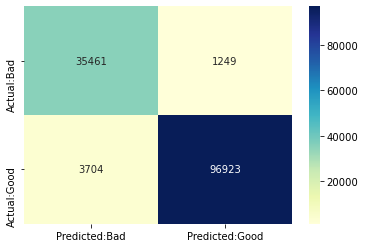

In [38]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))

con_mat = pd.DataFrame(
    confusion_matrix(lr.predict(testX), testY),
    columns = ['Predicted:Bad', 'Predicted:Good'],
    index = ['Actual:Bad', 'Actual:Good']
)


print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [39]:
mnb = MultinomialNB()

In [40]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [41]:
mnb.score(testX,testY)

0.9575205516357573

In [42]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9741801756757741
Testing Accuracy : 0.9575205516357573
              precision    recall  f1-score   support

         Bad       0.91      0.94      0.92     38237
        Good       0.98      0.97      0.97     99100

    accuracy                           0.96    137337
   macro avg       0.94      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337



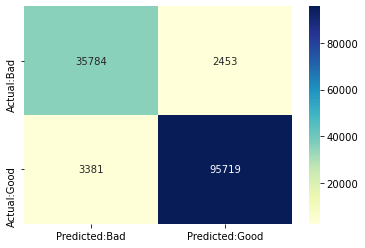

In [43]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))

con_mat = pd.DataFrame(
    confusion_matrix(mnb.predict(testX), testY),
    columns = ['Predicted:Bad', 'Predicted:Good'],
    index = ['Actual:Bad', 'Actual:Good']
)


print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

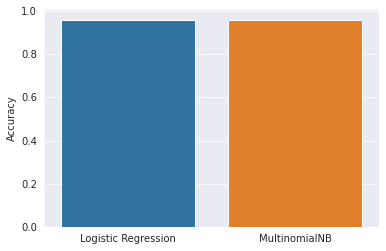

In [44]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

In [45]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [46]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [47]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('logisticregression', LogisticRegression())])

In [48]:
pipeline_ls.score(testX,testY) 

0.9657193618616978

Training Accuracy : 0.9805513957219382
Testing Accuracy : 0.9657193618616978
              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36994
        Good       0.99      0.96      0.98    100343

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337



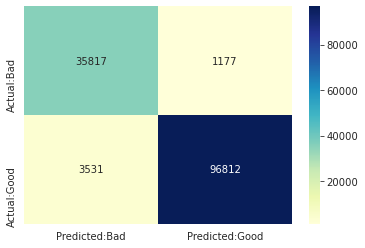

In [49]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))

con_mat = pd.DataFrame(
    confusion_matrix(pipeline_ls.predict(testX), testY),
    columns = ['Predicted:Bad', 'Predicted:Good'],
    index = ['Actual:Bad', 'Actual:Good']
)


print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [50]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [51]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9657193618616978


In [60]:
url = ["fik.unm.ac.id"]

loaded_model = pickle.load(open('phishing.pkl', 'rb'))

result = loaded_model.predict(url)

print(result)

['good']


In [71]:
import pickle
import numpy as np
import pandas as pd

def predict_url_with_details(url, model_path='phishing.pkl'):
    loaded_model = pickle.load(open(model_path, 'rb'))
    
    if isinstance(url, str):
        url = [url]
    
    predictions = loaded_model.predict(url)
    
    probabilities = loaded_model.predict_proba(url)
    
    classes = loaded_model.classes_
    
    results = []
    for i, single_url in enumerate(url):
        pred = predictions[i]
        probs = probabilities[i]
        
        pred_idx = np.where(classes == pred)[0][0]
        confidence = probs[pred_idx] * 100
        
        result = {
            'url': single_url,
            'prediction': pred,
            'confidence': round(confidence, 2),
            'probability_bad': round(probs[0] * 100, 2) if classes[0] == 'bad' else round(probs[1] * 100, 2),
            'probability_good': round(probs[1] * 100, 2) if classes[1] == 'good' else round(probs[0] * 100, 2),
            'is_safe': pred == 'good',
            'risk_level': get_risk_level(confidence, pred)
        }
        results.append(result)
    
    return results

def get_risk_level(confidence, prediction):
    if prediction == 'good':
        if confidence >= 90:
            return 'Very Low Risk'
        elif confidence >= 70:
            return 'Low Risk'
        else:
            return 'Moderate Risk'
    else:
        if confidence >= 90:
            return 'Critical Risk'
        elif confidence >= 70:
            return 'High Risk'
        else:
            return 'Moderate Risk'

def print_prediction_report(result):
    if isinstance(result, dict):
        result = [result]
    
    for i, res in enumerate(result, 1):
        if len(result) > 1:
            print(f"URL #{i}: {res['url']}")
        else:
            print(f"URL: {res['url']}")
        print_single_result(res)

def print_single_result(result):
    print(f"Prediction:      {result['prediction'].upper()}")
    print(f"Confidence:      {result['confidence']}%")
    print(f"Risk Level:      {result['risk_level']}")
    print(f"Safe to visit:   {'✓ YES' if result['is_safe'] else '✗ NO'}")
    print(f"\nProbability Breakdown:")
    print(f"  - Bad (Phishing):  {result['probability_bad']}%")
    print(f"  - Good (Legitimate): {result['probability_good']}%")

if __name__ == "__main__":
    single_result = predict_url_with_details("spotify.com")
    print_prediction_report(single_result)
    
    df_single = pd.DataFrame([single_result] if isinstance(single_result, dict) else single_result)
    print("\n", df_single.to_string(index=False))

URL: spotify.com
Prediction:      GOOD
Confidence:      80.94%
Risk Level:      Low Risk
Safe to visit:   ✓ YES

Probability Breakdown:
  - Bad (Phishing):  19.06%
  - Good (Legitimate): 80.94%

          url prediction  confidence  probability_bad  probability_good  is_safe risk_level
 spotify.com       good       80.94            19.06             80.94     True   Low Risk
